<hr style="color:green" />
<h1 style="color:green">COSC2673 Assignment 2: Image Classification for Cancerous Cells</h1>
<h2 style="color:green">File 07: Basic PyTorch Fully Connected Neural Network model test on Main data, 4 layers</h2>
<hr style="color:green" />

<p>
In this file, Train a basic fully connected NN with Pytorch, using a basic 4 layer configuration
</p>

In [28]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image


Configure this script as to whether it runs on Google Colab, or locally

In [29]:
# When on Google Colab, running full training, change both to true. Locally, advised set both to false
isGoogleColab = False
useFullData = False

In [30]:
# In local, the base directory is the current directory
baseDirectory = "./"

if isGoogleColab:
    from google.colab import drive
    
    # If this is running on Google colab, assume the notebook runs in a "COSC2673" folder, which also contains the data files 
    # in a subfolder called "image_classification_data"
    drive.mount("/content/drive")
    !ls /content/drive/'My Drive'/COSC2673/

    # Import the directory so that custom python libraries can be imported
    import sys
    sys.path.append("/content/drive/MyDrive/COSC2673/")

    # Set the base directory to the Google Drive specific folder
    baseDirectory = "/content/drive/MyDrive/COSC2673/"

Import the custom python files that contain reusable code

In [31]:
import data_basic_utility as dbutil
import graphing_utility as graphutil
import statistics_utility as statsutil

import a2_utility as a2util
import pytorch_utility as ptutil
from pytorch_utility import CancerBinaryDataset
from pytorch_utility import CancerCellTypeDataset


# randomSeed = dbutil.get_random_seed()
randomSeed = 266305
print("Random Seed: " + str(randomSeed))

Random Seed: 266305


In [32]:
# this file should have previously been created in the root directory
dfImages = pd.read_csv(baseDirectory + "images_main.csv")

In [33]:
# Get The training Split and the Validation Split
dfImagesTrain = dfImages[dfImages["trainValTest"] == 0].reset_index()
dfImagesVal = dfImages[dfImages["trainValTest"] == 1].reset_index()
dfImagesTest = dfImages[dfImages["trainValTest"] == 2].reset_index()

dfImagesTrain.head()

,index,ImageName,isCancerous,cellType,trainValTest
0,0,./Image_classification_data/patch_images\1.png,0,0,0
1,1,./Image_classification_data/patch_images\10.png,0,0,0
2,3,./Image_classification_data/patch_images\1000.png,1,2,0
3,4,./Image_classification_data/patch_images\10000...,0,1,0
4,5,./Image_classification_data/patch_images\10001...,0,1,0


Note: The definition of the Custom Datasets for both the isCancerous data and the Cell Type data are defined in the pytorch_utility.py file.

Also, rather than loading all the training images and calculating the mean and standard deviation values in here, that was run separately in file 05a.PyTorchGetMeanAndStd.ipynb

Here we can just define the values to use, which shouldn't change unless the data is reloaded and a new train/validation/test split is generated

In [34]:
train_mean, train_std = ptutil.getTrainMeanAndStdTensors()
print(train_mean)
print(train_std)

tensor([0.8035, 0.5909, 0.7640])
tensor([0.1246, 0.1947, 0.1714])


In [35]:
# Create a tranform operation that also normalizes the images according to the mean and standard deviations of the images
transform_normalize = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.ToTensor(), 
    transforms.Normalize(train_mean, train_std)])


In [36]:
cancerous_training_data = None

# Create a custom Dataset for the training and validation data
if useFullData:
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrain, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainTest = dfImagesTrain.iloc[range(1000), :].reset_index()
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrainTest, baseDirectory, transform=transform_normalize, target_transform=None)

cancerous_validation_data = CancerBinaryDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize, target_transform=None)
cancerous_test_data = CancerBinaryDataset(isGoogleColab, dfImagesTest, baseDirectory, transform=transform_normalize, target_transform=None)

# Create data loaders
cancerous_train_dataloader = DataLoader(cancerous_training_data, batch_size=32, shuffle=True, num_workers=2)
cancerous_val_dataloader = DataLoader(cancerous_validation_data, batch_size=32, shuffle=True, num_workers=2)
cancerous_test_dataloader = DataLoader(cancerous_test_data, batch_size=32, shuffle=True, num_workers=2)

Now, create a class for the basic, Fully Connected Neural Network. For this basic NN, we will use 3 fully connected layers. The number of features in this will be 27 x 27 x 3, or 2187.

Layer 1: Input is the images, which are 27 x 27 pixels, with 3 color values (RGB). Experiment initially with 1458 nodes
Layer 2: Input is 1458 from the the previous layer, down to 729
Layer 3: Input is 729 from the the previous layer, since this is a binary classification problem, the output will be 2 classes

In this, we will use the **ReLU** Activation Function. This is the Rectified Linear Unit function, which allows the function to become non-linear

In [37]:
# Create a class for the Neural Network
class PT_NN_IsCancerous(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_NN_IsCancerous, self).__init__()
        self.fc1 = nn.Linear(27 * 27 * 3, 1458)
        self.fc2 = nn.Linear(1458, 1094)
        self.fc3 = nn.Linear(1094, 729)
        self.fc4 = nn.Linear(729, 2)

    # Create the forward function, which is used in training
    def forward(self, x):
        # process through each layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        # return the result
        return x


Now train the Fully Connected Neural Network Model.

During training, we will use the following:
- Softmax Cross Entropy Loss as our Loss function. This is a good Loss function that basically converts scores for each class into probabilities
- The Adam Optimizer, which is a version of Gradient Descent
- Initially, just 10 epochs

In [38]:
# set the Learning Rate to use
learning_rate = 0.00003
epochsToUse = 10

net = PT_NN_IsCancerous()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(epochsToUse):
    print("Starting Epoch " + str(epoch) + "...")
    for i, data in enumerate(cancerous_train_dataloader, 0):
        # Get the inputs
        inputs, labels = data

        # This should convert the image tensors into vectors
        inputs = inputs.view(-1, 27 * 27 * 3)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Perform Forward and Backward propagation then optimize the weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

Starting Epoch 0...
Starting Epoch 1...
Starting Epoch 2...
Starting Epoch 3...
Starting Epoch 4...
Starting Epoch 5...
Starting Epoch 6...
Starting Epoch 7...
Starting Epoch 8...
Starting Epoch 9...


Training Time in Nelson's Local Environment on the full data takes a very long time, stopped after 100 minutes. This will need to be done in Colab.

First, Predict on the training data so that we can find the training error.

In [39]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

step=0

y_train_cancerous = []
y_train_pred_cancerous = []

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(cancerous_train_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_train_cancerous.append(labels[j].item())
        y_train_pred_cancerous.append(predicted[j].item())

    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print("Evaluate the Training Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_train_cancerous, y_train_pred_cancerous))

print("\n- Accuracy Score: " + str(accuracy_score(y_train_cancerous, y_train_pred_cancerous)))
print("- Precision Score: " + str(precision_score(y_train_cancerous, y_train_pred_cancerous)))
print("- Recall Score: " + str(recall_score(y_train_cancerous, y_train_pred_cancerous)))
print("- F1 Score: " + str(f1_score(y_train_cancerous, y_train_pred_cancerous)))

Evaluate the Training Predictions and Error: 

Confusion matrix: 

[[426   0]
 [  0 574]]

- Accuracy Score: 1.0
- Precision Score: 1.0
- Recall Score: 1.0
- F1 Score: 1.0


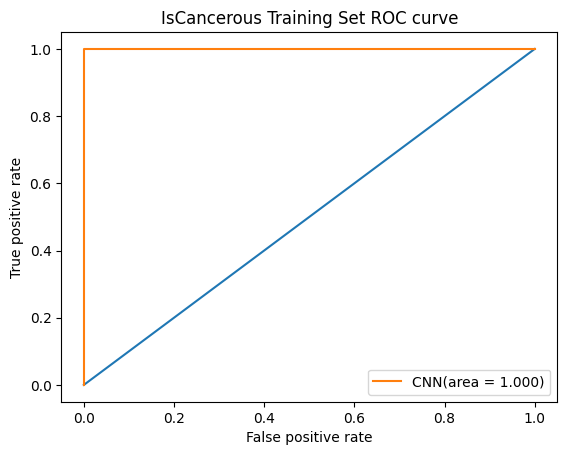

ROC (Area): 1.0


1.0

In [40]:
a2util.getClassificationROC("IsCancerous", "Training", y_train_cancerous, y_train_pred_cancerous)

Now Predict according to the Validation data and evaluate. While looping through here, we will need to get out the Labels from the data loader, because the order of predictions in the batches do not match the order of the original Target values in the dataset (because we turned Shuffle on)

In [41]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

step=0

y_test_cancerous = []
y_test_pred_cancerous = []

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(cancerous_test_dataloader, 0):
    inputs, labels = data


    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)
    class_score, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_test_cancerous.append(labels[j].item())
        y_test_pred_cancerous.append(predicted[j].item())

    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()



print("Evaluate the Test Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_test_cancerous, y_test_pred_cancerous))

print("\n- Accuracy Score: " + str(accuracy_score(y_test_cancerous, y_test_pred_cancerous)))
print("- Precision Score: " + str(precision_score(y_test_cancerous, y_test_pred_cancerous)))
print("- Recall Score: " + str(recall_score(y_test_cancerous, y_test_pred_cancerous)))
print("- F1 Score: " + str(f1_score(y_test_cancerous, y_test_pred_cancerous)))

Evaluate the Test Predictions and Error: 

Confusion matrix: 

[[297 108]
 [ 42 581]]

- Accuracy Score: 0.8540856031128404
- Precision Score: 0.8432510885341074
- Recall Score: 0.9325842696629213
- F1 Score: 0.8856707317073169


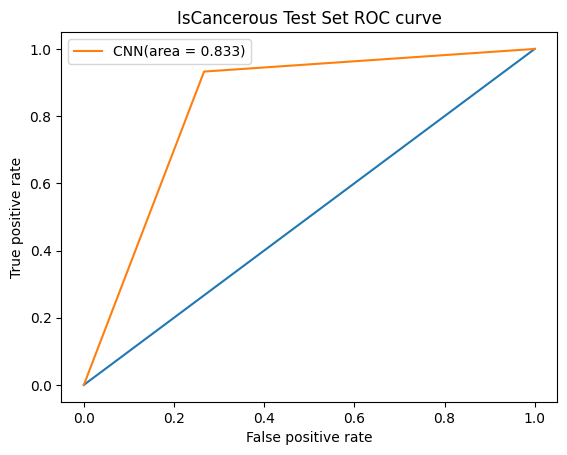

ROC (Area): 0.8329588014981274


0.8329588014981274

In [42]:
a2util.getClassificationROC("IsCancerous", "Test", y_test_cancerous, y_test_pred_cancerous, 2)

In [43]:
for i in range(3):
    print(predictions[i])

print(len(predictions))

tensor([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 0])
33


In [44]:
# y_val_pred_cancerous = [item for sublist in y_val_pred_cancerous for item in sublist]
print("Labels")
for i in range(5):
    print(y_test_cancerous[i])

print("Predictions")
for i in range(5):
    print(y_test_pred_cancerous[i])

Labels
1
1
1
1
0
Predictions
1
1
1
1
0


Now also train a model for CellType Predictions

In [45]:
celltype_training_data = None

# Create a custom Dataset for the training and validation data
if useFullData:
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrain, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainTest = dfImagesTrain.iloc[range(1000), :].reset_index()
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrainTest, baseDirectory, transform=transform_normalize, target_transform=None)


celltype_validation_data = CancerCellTypeDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize)
celltype_test_data = CancerCellTypeDataset(isGoogleColab, dfImagesTest, baseDirectory, transform=transform_normalize)

# Create data loaders
celltype_train_dataloader = DataLoader(celltype_training_data, batch_size=32, shuffle=True, num_workers=2)
celltype_val_dataloader = DataLoader(celltype_validation_data, batch_size=32, shuffle=True, num_workers=2)
celltype_test_dataloader = DataLoader(celltype_test_data, batch_size=32, shuffle=True, num_workers=2)

Create a class for the Cell Type Neural Network model. The structure of the class will be fundamentally the same, only the model will need to output 4 classes

In [46]:
# Create a class for the Neural Network
class PT_NN_CellType(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_NN_CellType, self).__init__()
        self.fc1 = nn.Linear(27 * 27 * 3, 1458)
        self.fc2 = nn.Linear(1458, 1094)
        self.fc3 = nn.Linear(1094, 729)
        self.fc4 = nn.Linear(729, 4)

    # Create the forward function, which is used in training
    def forward(self, x):
        # process through each layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        # return the result
        return x

Now train the Fully Connected Neural Network Model. Use the same configuration (objective function, optimizer etc) as the Binary Classifier

In [47]:
# set the Learning Rate to use
learning_rate = 0.00003
epochsToUse = 10

net = PT_NN_CellType()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(epochsToUse):
    print("Starting Epoch " + str(epoch) + "...")
    for i, data in enumerate(celltype_train_dataloader, 0):
        # Get the inputs
        inputs, labels = data

        # This should convert the image tensors into vectors
        inputs = inputs.view(-1, 27 * 27 * 3)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Perform Forward and Backward propagation then optimize the weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

Starting Epoch 0...
Starting Epoch 1...
Starting Epoch 2...
Starting Epoch 3...
Starting Epoch 4...
Starting Epoch 5...
Starting Epoch 6...
Starting Epoch 7...
Starting Epoch 8...
Starting Epoch 9...


Predict on the Training Set to get the Training Accuracy and Error

In [48]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

y_train_celltype = []
y_train_pred_celltype = []
y_train_pred_celltype_scores = []

showBatch=True

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(celltype_train_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)

    # outputs.data contains a tensor of size 4 for each record, with a score for each class. Use max
    # to select the class of the highest score for the prediction.
    class_score, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_train_celltype.append(labels[j].item())
        y_train_pred_celltype.append(predicted[j].item())
        y_train_pred_celltype_scores.append(outputs.data[j].tolist())

    showBatch = False
    
    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print("Evaluate the Training Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_train_celltype, y_train_pred_celltype))

print("\n- Accuracy Score: " + str(accuracy_score(y_train_celltype, y_train_pred_celltype)))
print("- Precision Score: " + str(precision_score(y_train_celltype, y_train_pred_celltype, average="micro")))
print("- Recall Score: " + str(recall_score(y_train_celltype, y_train_pred_celltype, average="micro")))
print("- F1 Score: " + str(f1_score(y_train_celltype, y_train_pred_celltype, average="micro")))

Evaluate the Training Predictions and Error: 

Confusion matrix: 

[[106   3  11   6]
 [  1 133   2   2]
 [  0   0 573   1]
 [  2   0   2 158]]

- Accuracy Score: 0.97
- Precision Score: 0.97
- Recall Score: 0.97
- F1 Score: 0.97


In [49]:
for i in range(5):
    print(y_train_pred_celltype_scores[i])

[-1.9422721862792969, -4.693204879760742, 6.448698997497559, -2.061736583709717]
[-0.7201947569847107, -0.3411552906036377, -0.7811980843544006, 2.3330674171447754]
[-0.775384783744812, 1.2613401412963867, -2.592179536819458, 3.0333714485168457]
[-0.30044257640838623, 3.0656344890594482, -1.2347980737686157, -1.0354331731796265]
[-0.6371626257896423, -3.413989543914795, 5.858743190765381, -3.527426242828369]


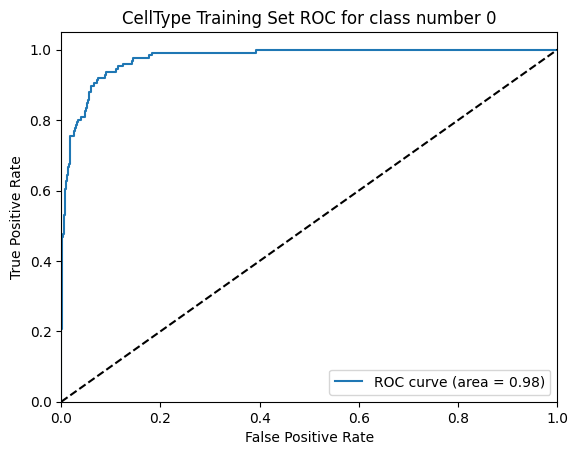

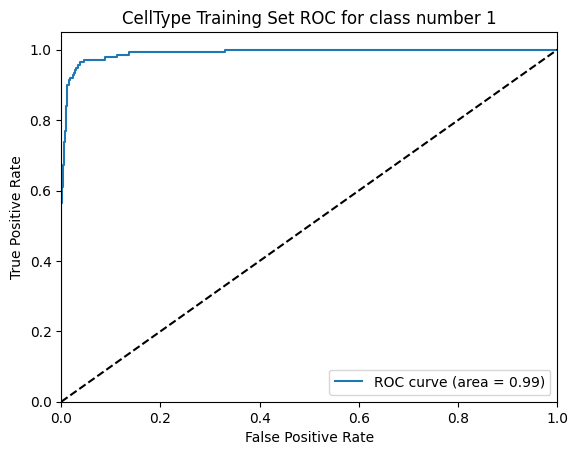

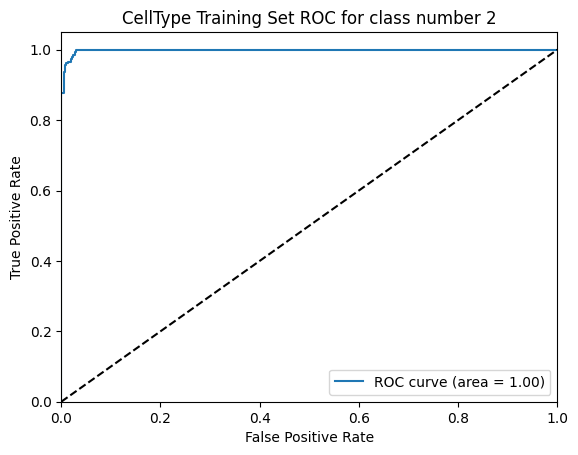

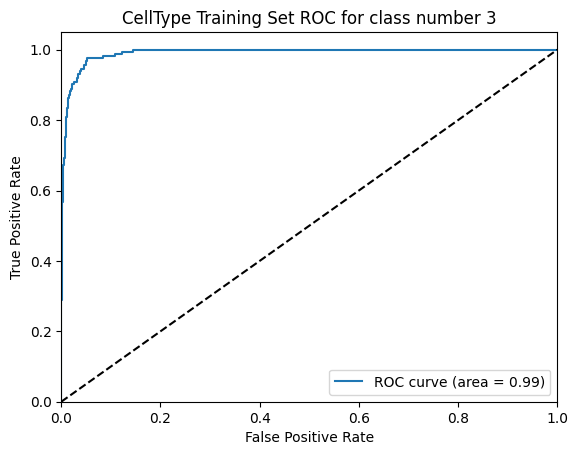

Mean ROC (Area): 0.9890981149160372


0.9890981149160372

In [50]:
a2util.getClassificationROC("CellType", "Training", y_train_celltype, y_train_pred_celltype, 4, y_train_pred_celltype_scores)

Predict on the Validation data and evaluate the results

In [51]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

step=0

y_test_celltype = []
y_test_pred_celltype = []
y_test_pred_celltype_scores = []

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(celltype_test_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)
    class_score, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_test_celltype.append(labels[j].item())
        y_test_pred_celltype.append(predicted[j].item())
        y_test_pred_celltype_scores.append(outputs.data[j].tolist())

    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


accuracy = (correct/total) * 100
print("Evaluate the Test Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_test_celltype, y_test_pred_celltype))

print("\n- Accuracy Score: " + str(accuracy_score(y_test_celltype, y_test_pred_celltype)))
print("- Precision Score: " + str(precision_score(y_test_celltype, y_test_pred_celltype, average="micro")))
print("- Recall Score: " + str(recall_score(y_test_celltype, y_test_pred_celltype, average="micro")))
print("- F1 Score: " + str(f1_score(y_test_celltype, y_test_pred_celltype, average="micro")))

Evaluate the Test Predictions and Error: 

Confusion matrix: 

[[ 44  20  38  38]
 [ 32  51  48  54]
 [  9   8 593  13]
 [  7  16  38  19]]

- Accuracy Score: 0.6877431906614786
- Precision Score: 0.6877431906614786
- Recall Score: 0.6877431906614786
- F1 Score: 0.6877431906614786


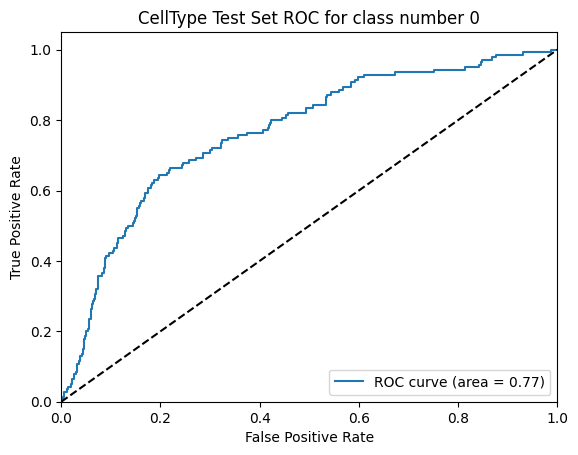

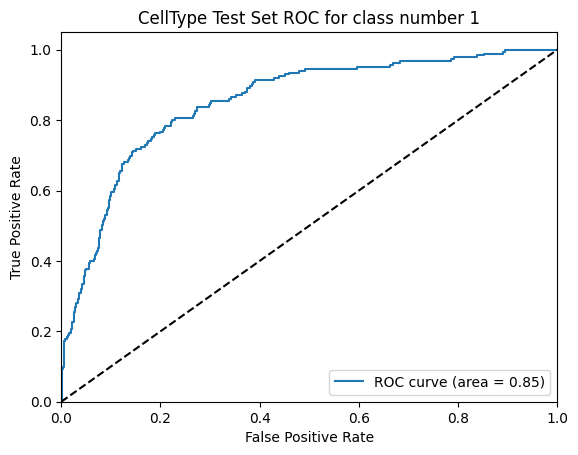

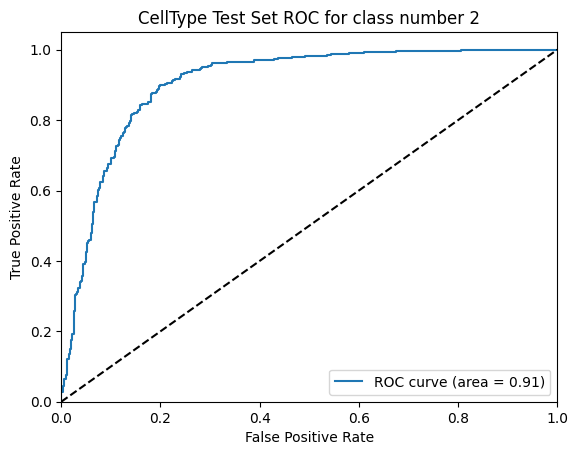

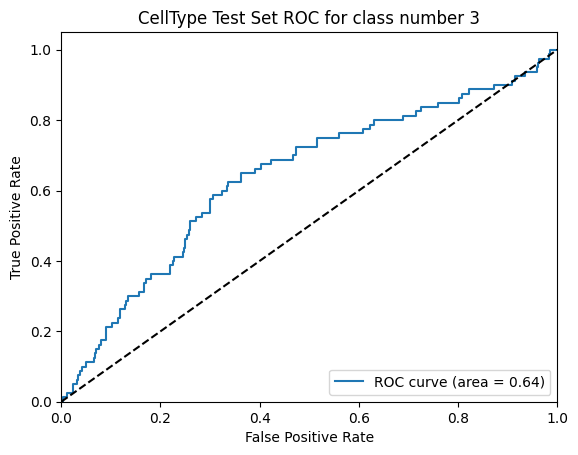

Mean ROC (Area): 0.7904455506882757


0.7904455506882757

In [52]:
a2util.getClassificationROC("CellType", "Test", y_test_celltype, y_test_pred_celltype, 4, y_test_pred_celltype_scores)

### IsCancerous Results

Baseline, 2 Layer - SGD optimiser
- **Training**
- **Test**


Basic, 4 Layer - Adam optimiser
- **Training**
- Accuracy Score: 1.0
- Precision Score: 1.0
- Recall Score: 1.0
- F1 Score: 1.0
- **Test**
- Accuracy Score: 0.8540856031128404
- Precision Score: 0.8432510885341074
- Recall Score: 0.9325842696629213
- F1 Score: 0.8856707317073169

### Cell Type

- **Training**
- Accuracy Score: 0.97
- Precision Score: 0.97
- Recall Score: 0.97
- F1 Score: 0.97
- **Test**
- Accuracy Score: 0.6877431906614786
- Precision Score: 0.6877431906614786
- Recall Score: 0.6877431906614786
- F1 Score: 0.6877431906614786

<h1>Analysis of Performance and Accuracy</h1>

<strong>Binary Classification - IsCancerous</strong>
<p>
In this model we see that the model has a very low training error and a high accuracy value, in this experiment achieving a 100% accuracy. This indicates that the model has <strong>low bias</strong>. However, when predicting on the validation dataset, the validation error rises. It can be seen that the Accuracy for the validation predictions is 84%, and the are under the ROC Curve is significantly less, with a value of 0.82. This is an indication of <strong>high variance</strong>, and in combination with low bias, indicates a possible problem of <strong>overfitting</strong>
</p>

<strong>Multi-class Classification - Cell Type</strong>
<p>
Similarly, the Cell Type model has a very low training error and a high accuracy value of 99.17%, indicating that the model has <strong>low bias</strong>. However, the Cell Type model has a considerably worse accuracy of only 72.94% when predicting on the validation dataset. A ROC curve is generated for each class, and it can be seen that the model performs better at predicting some classes compared to others. The average the under the ROC Curve score, with a value of 0.84. This indication of <strong>high variance</strong>, and in combination with low bias, indicates a possible problem of <strong>overfitting</strong>.
</p>